# Binary variables on both production and consumption

## First Try

In [1]:
import pandas as pd
import os
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from datetime import datetime

# Paths to directories
Data_path_GDrive = "G:/Il mio Drive/Thesis_Large_Files/Working Table"
Data_path_Production = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Production"
Data_path_Consumption = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Consumption"
Data_path_Users = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Users"
results_dir = 'C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results'
results_dir = os.path.join(results_dir, datetime.now().strftime('%Y-%m-%d_%H-%M-%S')+ 'BinaryProductionandConsumption')
os.makedirs(results_dir, exist_ok=True)

# Load Working Tables for every optimization try
WorkingTables_Path = 'C:/Users/Nik/Documents/GitHub/Thesis/CSV/Working Tables'
DF_m2_Residential = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Residential.csv'), sep=",", on_bad_lines='skip', header=0)
DF_m2_Industrial = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Industrial.csv'), sep=",", on_bad_lines='skip', header=0)
DF_m2_Commercial = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Commercial.csv'), sep=",", on_bad_lines='skip', header=0)

Residential_user_production_df = pd.read_csv(os.path.join(Data_path_GDrive, 'Residential_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
Industrial_user_production_df = pd.read_csv(os.path.join(WorkingTables_Path, 'Industrial_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
Commercial_user_production_df = pd.read_csv(os.path.join(WorkingTables_Path, 'Commercial_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])

# Load New Consumption Curves
Residential_Consumption = pd.read_csv('C:/Users/Nik/Documents/GitHub/Thesis/CSV/Consumption/Residential_Consumption_Optimized_From_Switched_2.csv', index_col=0, parse_dates=True)
Industrial_Consumption = pd.read_csv('C:/Users/Nik/Documents/GitHub/Thesis/CSV/Consumption/Industrial_Consumption_Optimized_From_Switched_2.csv', index_col=0, parse_dates=True)
Commercial_Consumption = pd.read_csv('C:/Users/Nik/Documents/GitHub/Thesis/CSV/Consumption/Commercial_Consumption_Optimized_From_Switched_2.csv', index_col=0, parse_dates=True)

DF_Production = pd.read_csv(os.path.join(Data_path_Production, '2019_Production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])

# Use 'full_id' as the primary identifier
residential_users = DF_m2_Residential['full_id'].astype(str).tolist()
industrial_users = DF_m2_Industrial['full_id'].astype(str).tolist()
commercial_users = DF_m2_Commercial['full_id'].astype(str).tolist()

# Precompute area mappings to avoid repeated DataFrame lookups
residential_area_dict = DF_m2_Residential.set_index('full_id')['Area'].to_dict()
industrial_area_dict = DF_m2_Industrial.set_index('full_id')['Area'].to_dict()
commercial_area_dict = DF_m2_Commercial.set_index('full_id')['Area'].to_dict()

# Define the yearlist based on the number of hours
yearlist = DF_Production.index

# Fixed consumption area to achieve
Fixed_Res_Consumption_Area = 50000  # Example value
Fixed_Ind_Consumption_Area = 1000   # Example value
Fixed_Com_Consumption_Area = 2000   # Example value

# Create a new Gurobi model
m = gp.Model("Optimization_Model_ConsumptionProduction")

# Production and Consumption Binary Variables [0;1]
binary_vars_production_residential = m.addVars(residential_users, vtype=GRB.BINARY, name="binary_production_residential")
binary_vars_consumption_residential = m.addVars(residential_users, vtype=GRB.BINARY, name="binary_consumption_residential")

binary_vars_production_industrial = m.addVars(industrial_users, vtype=GRB.BINARY, name="binary_production_industrial")
binary_vars_consumption_industrial = m.addVars(industrial_users, vtype=GRB.BINARY, name="binary_consumption_industrial")

binary_vars_production_commercial = m.addVars(commercial_users, vtype=GRB.BINARY, name="binary_production_commercial")
binary_vars_consumption_commercial = m.addVars(commercial_users, vtype=GRB.BINARY, name="binary_consumption_commercial")

# Auxiliary variable for absolute deviation
deviation = m.addVars(yearlist, lb=0, vtype=GRB.CONTINUOUS, name="deviation")

# Penalty coefficient for not selecting users
penalty_coefficient = 100  # Adjust this value to control the penalization effect

# Pre-compute consumption and production terms for each user and hour
residential_prod_terms = {
    t: {user: Residential_user_production_df.loc[t, user] for user in residential_users if user in Residential_user_production_df.columns}
    for t in yearlist
}
industrial_prod_terms = {
    t: {user: Industrial_user_production_df.loc[t, user] for user in industrial_users if user in Industrial_user_production_df.columns}
    for t in yearlist
}
commercial_prod_terms = {
    t: {user: Commercial_user_production_df.loc[t, user] for user in commercial_users if user in Commercial_user_production_df.columns}
    for t in yearlist
}

residential_cons_terms = {
    t: {user: Residential_Consumption[f'Residential_User_{user}_Mixed'].loc[t] * residential_area_dict[user]
        for user in residential_users if f'Residential_User_{user}_Mixed' in Residential_Consumption.columns}
    for t in yearlist
}
industrial_cons_terms = {
    t: {user: Industrial_Consumption[f'Industrial_User_{user}_Mixed'].loc[t] * industrial_area_dict[user]
        for user in industrial_users if f'Industrial_User_{user}_Mixed' in Industrial_Consumption.columns}
    for t in yearlist
}
commercial_cons_terms = {
    t: {user: Commercial_Consumption[f'Commercial_User_{user}_Mixed'].loc[t] * commercial_area_dict[user]
        for user in commercial_users if f'Commercial_User_{user}_Mixed' in Commercial_Consumption.columns}
    for t in yearlist
}

print("finish precomputing")

# Calculate the difference between production and consumption for each hour using precomputed terms
for t in yearlist:
    production_res = gp.quicksum(binary_vars_production_residential[user] * residential_prod_terms[t].get(user, 0) for user in residential_users)
    consumption_res = gp.quicksum(binary_vars_consumption_residential[user] * residential_cons_terms[t].get(user, 0) for user in residential_users)
    
    production_ind = gp.quicksum(binary_vars_production_industrial[user] * industrial_prod_terms[t].get(user, 0) for user in industrial_users)
    consumption_ind = gp.quicksum(binary_vars_consumption_industrial[user] * industrial_cons_terms[t].get(user, 0) for user in industrial_users)
    
    production_com = gp.quicksum(binary_vars_production_commercial[user] * commercial_prod_terms[t].get(user, 0) for user in commercial_users)
    consumption_com = gp.quicksum(binary_vars_consumption_commercial[user] * commercial_cons_terms[t].get(user, 0) for user in commercial_users)
    
    difference = production_res - consumption_res + production_ind - consumption_ind + production_com - consumption_com
    
    # Add constraints for deviation
    m.addConstr(deviation[t] >= difference, name=f"PosDeviation_{t}")
    m.addConstr(deviation[t] >= -difference, name=f"NegDeviation_{t}")

# Constraint: Total selected consumption area must equal or exceed the fixed value
m.addConstr(
    gp.quicksum(binary_vars_consumption_residential[user] * residential_area_dict[user] for user in residential_users) >= Fixed_Res_Consumption_Area,
    name="FixedResConsumptionArea"
)

# Constraint: Total selected industrial consumption area must equal or exceed the fixed value
m.addConstr(
    gp.quicksum(binary_vars_consumption_industrial[user] * industrial_area_dict[user] for user in industrial_users) >= Fixed_Ind_Consumption_Area,
    name="FixedIndConsumptionArea"
)

# Constraint: Total selected commercial consumption area must equal or exceed the fixed value
m.addConstr(
    gp.quicksum(binary_vars_consumption_commercial[user] * commercial_area_dict[user] for user in commercial_users) >= Fixed_Com_Consumption_Area,
    name="FixedComConsumptionArea"
)

# Objective function: minimize the deviation and penalize unselected users
penalty = (
    penalty_coefficient * (
        gp.quicksum(1 - binary_vars_production_residential[user] for user in residential_users) +
        gp.quicksum(1 - binary_vars_consumption_residential[user] for user in residential_users) +
        gp.quicksum(1 - binary_vars_production_industrial[user] for user in industrial_users) +
        gp.quicksum(1 - binary_vars_consumption_industrial[user] for user in industrial_users) +
        gp.quicksum(1 - binary_vars_production_commercial[user] for user in commercial_users) +
        gp.quicksum(1 - binary_vars_consumption_commercial[user] for user in commercial_users)
    )
)

# Minimize deviation and add penalization
m.setObjective(gp.quicksum(deviation[t] for t in yearlist) + penalty, GRB.MINIMIZE)

# Set solver parameters to potentially reduce runtime and monitor output
m.Params.OutputFlag = 1  # Ensure detailed output
m.Params.MIPGap = 0.01  # Set gap tolerance to 1% to allow faster convergence
m.Params.TimeLimit = 5400  # Set a time limit of 1.5 hours (5400 seconds) to prevent excessive runtimes
m.Params.Presolve = 2  # Aggressive presolve level
m.Params.Cuts = 2  # Apply aggressive cuts
m.Params.Heuristics = 0.5  # Increase the emphasis on heuristics to find feasible solutions faster

# Enable logging to file for detailed analysis later
m.Params.LogFile = os.path.join(results_dir, "optimization_log.txt")

# Optimize the model
m.optimize()

# Check for solution status
if m.Status == GRB.OPTIMAL:
    print("Optimal solution found!")
elif m.Status == GRB.INFEASIBLE:
    print("Model is infeasible.")
    m.computeIIS()  # Compute Irreducible Inconsistent Subsystem (IIS) to understand infeasibility
    m.write(os.path.join(results_dir, "model.ilp"))  # Save IIS to a file
elif m.Status == GRB.TIME_LIMIT:
    print("Optimization stopped due to time limit.")
else:
    print(f"Optimization ended with status {m.Status}.")

# Display the results
for v in m.getVars():
    print(f'{v.varName}: {v.x}')

print(f'Objective: {m.objVal}')

# Extract results for each user type
RP_values = {user: binary_vars_production_residential[user].X for user in residential_users}
CP_values = {user: binary_vars_consumption_residential[user].X for user in residential_users}
IP_values = {user: binary_vars_production_industrial[user].X for user in industrial_users}
CIP_values = {user: binary_vars_consumption_industrial[user].X for user in industrial_users}
CP_values_com = {user: binary_vars_production_commercial[user].X for user in commercial_users}
CIP_values_com = {user: binary_vars_consumption_commercial[user].X for user in commercial_users}

# Create new DataFrames with the chosen binary variables
DF_m2_Residential['Chosen_Production'] = [RP_values[user] for user in DF_m2_Residential['full_id']]
DF_m2_Residential['Chosen_Consumption'] = [CP_values[user] for user in DF_m2_Residential['full_id']]
DF_m2_Industrial['Chosen_Production'] = [IP_values[user] for user in DF_m2_Industrial['full_id']]
DF_m2_Industrial['Chosen_Consumption'] = [CIP_values[user] for user in DF_m2_Industrial['full_id']]
DF_m2_Commercial['Chosen_Production'] = [CP_values_com[user] for user in DF_m2_Commercial['full_id']]
DF_m2_Commercial['Chosen_Consumption'] = [CIP_values_com[user] for user in DF_m2_Commercial['full_id']]

# Extract chosen users based on optimization results
chosen_residential_production = DF_m2_Residential[DF_m2_Residential['Chosen_Production'] == 1]
chosen_residential_consumption = DF_m2_Residential[DF_m2_Residential['Chosen_Consumption'] == 1]
chosen_industrial_production = DF_m2_Industrial[DF_m2_Industrial['Chosen_Production'] == 1]
chosen_industrial_consumption = DF_m2_Industrial[DF_m2_Industrial['Chosen_Consumption'] == 1]
chosen_commercial_production = DF_m2_Commercial[DF_m2_Commercial['Chosen_Production'] == 1]
chosen_commercial_consumption = DF_m2_Commercial[DF_m2_Commercial['Chosen_Consumption'] == 1]

# Save the results to CSV files
chosen_residential_production.to_csv(os.path.join(results_dir, 'chosen_residential_production.csv'))
chosen_residential_consumption.to_csv(os.path.join(results_dir, 'chosen_residential_consumption.csv'))
chosen_industrial_production.to_csv(os.path.join(results_dir, 'chosen_industrial_production.csv'))
chosen_industrial_consumption.to_csv(os.path.join(results_dir, 'chosen_industrial_consumption.csv'))
chosen_commercial_production.to_csv(os.path.join(results_dir, 'chosen_commercial_production.csv'))
chosen_commercial_consumption.to_csv(os.path.join(results_dir, 'chosen_commercial_consumption.csv'))

# Calculate the number of chosen users versus the total number of users for each category
num_residential_chosen_production = len(chosen_residential_production)
num_residential_total = len(DF_m2_Residential)

num_residential_chosen_consumption = len(chosen_residential_consumption)
num_industrial_chosen_production = len(chosen_industrial_production)
num_industrial_total = len(DF_m2_Industrial)

num_industrial_chosen_consumption = len(chosen_industrial_consumption)
num_commercial_chosen_production = len(chosen_commercial_production)
num_commercial_total = len(DF_m2_Commercial)

num_commercial_chosen_consumption = len(chosen_commercial_consumption)

# Print the amounts
print(f'Residential Production: Chosen = {num_residential_chosen_production}, Total = {num_residential_total}')
print(f'Residential Consumption: Chosen = {num_residential_chosen_consumption}, Total = {num_residential_total}')
print(f'Industrial Production: Chosen = {num_industrial_chosen_production}, Total = {num_industrial_total}')
print(f'Industrial Consumption: Chosen = {num_industrial_chosen_consumption}, Total = {num_industrial_total}')
print(f'Commercial Production: Chosen = {num_commercial_chosen_production}, Total = {num_commercial_total}')
print(f'Commercial Consumption: Chosen = {num_commercial_chosen_consumption}, Total = {num_commercial_total}')


Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-30
finish precomputing
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 5400
Set parameter Presolve to value 2
Set parameter Cuts to value 2
Set parameter Heuristics to value 0.5
Set parameter LogFile to value "C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results\2024-09-09_12-21-46BinaryProductionandConsumption\optimization_log.txt"
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 17523 rows, 25084 columns and 143023922 nonzeros
Model fingerprint: 0x1e251183
Variable types: 8760 continuous, 16324 integer (16324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]


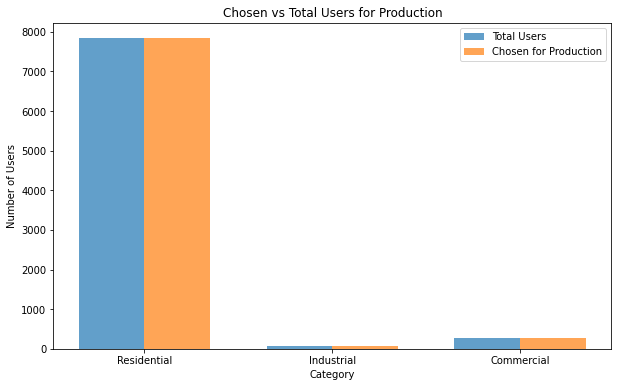

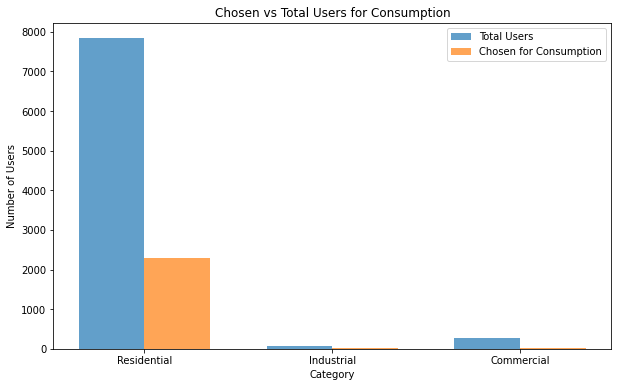

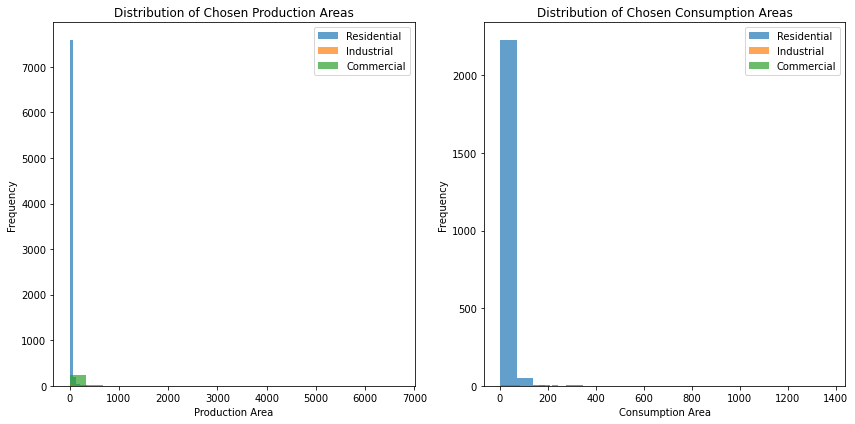

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these values with your actual results after optimization
num_residential_chosen_production = len(chosen_residential_production)
num_industrial_chosen_production = len(chosen_industrial_production)
num_commercial_chosen_production = len(chosen_commercial_production)

num_residential_total = len(DF_m2_Residential)
num_industrial_total = len(DF_m2_Industrial)
num_commercial_total = len(DF_m2_Commercial)

num_residential_chosen_consumption = len(chosen_residential_consumption)
num_industrial_chosen_consumption = len(chosen_industrial_consumption)
num_commercial_chosen_consumption = len(chosen_commercial_consumption)

# Data for plotting
categories = ['Residential', 'Industrial', 'Commercial']
chosen_production = [num_residential_chosen_production, num_industrial_chosen_production, num_commercial_chosen_production]
total_users = [num_residential_total, num_industrial_total, num_commercial_total]
chosen_consumption = [num_residential_chosen_consumption, num_industrial_chosen_consumption, num_commercial_chosen_consumption]

# Plotting Chosen vs Total Users for Production
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(categories))

plt.bar(x, total_users, width=bar_width, label='Total Users', alpha=0.7)
plt.bar(x + bar_width, chosen_production, width=bar_width, label='Chosen for Production', alpha=0.7)

plt.xlabel('Category')
plt.ylabel('Number of Users')
plt.title('Chosen vs Total Users for Production')
plt.xticks(x + bar_width / 2, categories)
plt.legend()
plt.show()

# Plotting Chosen vs Total Users for Consumption
plt.figure(figsize=(10, 6))

plt.bar(x, total_users, width=bar_width, label='Total Users', alpha=0.7)
plt.bar(x + bar_width, chosen_consumption, width=bar_width, label='Chosen for Consumption', alpha=0.7)

plt.xlabel('Category')
plt.ylabel('Number of Users')
plt.title('Chosen vs Total Users for Consumption')
plt.xticks(x + bar_width / 2, categories)
plt.legend()
plt.show()

# Use actual data from your chosen users for production and consumption areas
residential_production_areas = chosen_residential_production['Area'].values
industrial_production_areas = chosen_industrial_production['Area'].values
commercial_production_areas = chosen_commercial_production['Area'].values

residential_consumption_areas = chosen_residential_consumption['Area'].values
industrial_consumption_areas = chosen_industrial_consumption['Area'].values
commercial_consumption_areas = chosen_commercial_consumption['Area'].values

# Plotting Distribution of Chosen Production and Consumption Areas
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(residential_production_areas, bins=20, alpha=0.7, label='Residential')
plt.hist(industrial_production_areas, bins=20, alpha=0.7, label='Industrial')
plt.hist(commercial_production_areas, bins=20, alpha=0.7, label='Commercial')
plt.xlabel('Production Area')
plt.ylabel('Frequency')
plt.title('Distribution of Chosen Production Areas')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(residential_consumption_areas, bins=20, alpha=0.7, label='Residential')
plt.hist(industrial_consumption_areas, bins=20, alpha=0.7, label='Industrial')
plt.hist(commercial_consumption_areas, bins=20, alpha=0.7, label='Commercial')
plt.xlabel('Consumption Area')
plt.ylabel('Frequency')
plt.title('Distribution of Chosen Consumption Areas')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Ensure all production data indexes are in datetime format
Residential_user_production_df.index = pd.to_datetime(Residential_user_production_df.index)
Industrial_user_production_df.index = pd.to_datetime(Industrial_user_production_df.index)
Commercial_user_production_df.index = pd.to_datetime(Commercial_user_production_df.index)

# Initialize directories for saving plots
plot_dir = os.path.join(results_dir, 'Plot')
yearly_plot_dir = os.path.join(plot_dir, 'Yearly_Plot')
weekly_plot_dir = os.path.join(plot_dir, 'Weekly_Plot')
os.makedirs(yearly_plot_dir, exist_ok=True)
os.makedirs(weekly_plot_dir, exist_ok=True)

# Initialize a dictionary to store the results
weekly_results = {
    'Month': [],
    'F1_Percentage': [],
    'F2_Percentage': [],
    'F3_Percentage': [],
    '10am_to_4pm_Percentage': []
}

# Loop through each month to calculate percentages for each period and plot the first week of each month
for month in range(1, 13):
    start_date = f'2019-{month:02d}-01'
    end_date = f'2019-{month:02d}-07'

    # Filter data for the first week of the month
    week_data_index = pd.date_range(start=start_date, end=end_date, freq='H')

    # Calculate production for each user type
    week_production_residential = [
        sum(
            RP_values[user] * Residential_user_production_df.loc[date, user]
            for user in DF_m2_Residential.index
            if date in Residential_user_production_df.index
        ) for date in week_data_index
    ]

    week_production_industrial = [
        sum(
            IP_values[user] * Industrial_user_production_df.loc[date, user]
            for user in DF_m2_Industrial.index
            if date in Industrial_user_production_df.index
        ) for date in week_data_index
    ]

    week_production_commercial = [
        sum(
            CP_values[user] * Commercial_user_production_df.loc[date, user]
            for user in DF_m2_Commercial.index
            if date in Commercial_user_production_df.index
        ) for date in week_data_index
    ]

    week_production_total = [
        week_production_residential[i] + week_production_industrial[i] + week_production_commercial[i]
        for i in range(len(week_data_index))
    ]

    # Calculate total consumption for the week for each user category
    week_consumption_residential = [
        sum(
            Residential_Consumption.loc[date, f'Residential_User_{user}_Mixed'] * residential_area_dict[user]
            for user in DF_m2_Residential.index
            if date in Residential_Consumption.index
        ) for date in week_data_index
    ]

    week_consumption_industrial = [
        sum(
            Industrial_Consumption.loc[date, f'Industrial_User_{user}_Mixed'] * industrial_area_dict[user]
            for user in DF_m2_Industrial.index
            if date in Industrial_Consumption.index
        ) for date in week_data_index
    ]

    week_consumption_commercial = [
        sum(
            Commercial_Consumption.loc[date, f'Commercial_User_{user}_Mixed'] * commercial_area_dict[user]
            for user in DF_m2_Commercial.index
            if date in Commercial_Consumption.index
        ) for date in week_data_index
    ]

    week_consumption_total = [
        week_consumption_residential[i] + week_consumption_industrial[i] + week_consumption_commercial[i]
        for i in range(len(week_data_index))
    ]

    # Define F1, F2, F3 periods and 10am to 4pm
    F1_mask = (week_data_index.weekday < 5) & (week_data_index.hour >= 8) & (week_data_index.hour < 19)
    F2_mask = ((week_data_index.weekday < 5) & ((week_data_index.hour >= 7) & (week_data_index.hour < 8) | (week_data_index.hour >= 19) & (week_data_index.hour < 23))) | \
              ((week_data_index.weekday == 5) & (week_data_index.hour >= 7) & (week_data_index.hour < 23))
    F3_mask = ((week_data_index.weekday < 6) & (week_data_index.hour >= 23)) | (week_data_index.hour < 7) | (week_data_index.weekday == 6)
    time_10am_4pm_mask = (week_data_index.hour >= 10) & (week_data_index.hour < 16)

    # Calculate total production and consumption for each period
    total_production_F1 = sum([week_production_total[i] for i in range(len(week_data_index)) if F1_mask[i]])
    total_consumption_F1 = sum([week_consumption_total[i] for i in range(len(week_data_index)) if F1_mask[i]])
    F1_percentage = (total_production_F1 / total_consumption_F1) * 100 if total_consumption_F1 > 0 else 0

    total_production_F2 = sum([week_production_total[i] for i in range(len(week_data_index)) if F2_mask[i]])
    total_consumption_F2 = sum([week_consumption_total[i] for i in range(len(week_data_index)) if F2_mask[i]])
    F2_percentage = (total_production_F2 / total_consumption_F2) * 100 if total_consumption_F2 > 0 else 0

    total_production_F3 = sum([week_production_total[i] for i in range(len(week_data_index)) if F3_mask[i]])
    total_consumption_F3 = sum([week_consumption_total[i] for i in range(len(week_data_index)) if F3_mask[i]])
    F3_percentage = (total_production_F3 / total_consumption_F3) * 100 if total_consumption_F3 > 0 else 0

    total_production_10am_4pm = sum([week_production_total[i] for i in range(len(week_data_index)) if time_10am_4pm_mask[i]])
    total_consumption_10am_4pm = sum([week_consumption_total[i] for i in range(len(week_data_index)) if time_10am_4pm_mask[i]])
    percentage_10am_4pm = (total_production_10am_4pm / total_consumption_10am_4pm) * 100 if total_consumption_10am_4pm > 0 else 0

    # Append results for each month
    weekly_results['Month'].append(month)
    weekly_results['F1_Percentage'].append(F1_percentage)
    weekly_results['F2_Percentage'].append(F2_percentage)
    weekly_results['F3_Percentage'].append(F3_percentage)
    weekly_results['10am_to_4pm_Percentage'].append(percentage_10am_4pm)

    # Plotting
    def plot_production_vs_consumption(time_series, production, consumption, label, color, month):
        plt.figure(figsize=(12, 6))
        plt.plot(time_series, production, label=f'{label} Production', color=color)
        plt.plot(time_series, consumption, label='Total Consumption', color='red')
        plt.xlabel('Time')
        plt.ylabel('Energy (W)')
        plt.title(f'{label} Production vs. Total Consumption (First Week of Month {month:02d})')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(weekly_plot_dir, f'{label}_Production_vs_Total_Consumption_Week_{month:02d}.png'))
        plt.show()

    # Plot total production vs total consumption
    plot_production_vs_consumption(week_data_index, week_production_total, week_consumption_total, 'Total', 'blue', month)
                                    
    # Plot residential production vs total consumption
    plot_production_vs_consumption(week_data_index, week_production_residential, week_consumption_total, 'Residential', 'blue', month)

    # Plot industrial production vs total consumption
    plot_production_vs_consumption(week_data_index, week_production_industrial, week_consumption_total, 'Industrial', 'green', month)

    # Plot commercial production vs total consumption
    plot_production_vs_consumption(week_data_index, week_production_commercial, week_consumption_total, 'Commercial', 'orange', month)

# Convert results to DataFrame
weekly_results_df = pd.DataFrame(weekly_results)

# Save the results to Excel and CSV
output_file_path_excel = os.path.join(weekly_plot_dir, 'Weekly_Percentage_Results.xlsx')
output_file_path_csv = os.path.join(weekly_plot_dir, 'Weekly_Percentage_Results.csv')

weekly_results_df.to_excel(output_file_path_excel, index=False)
weekly_results_df.to_csv(output_file_path_csv, index=False)

print(f'Results saved to {output_file_path_excel} and {output_file_path_csv}')



KeyError: '0'

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Ensure all production data indexes are in datetime format
Industrial_user_production_df.index = pd.to_datetime(Industrial_user_production_df.index)
Commercial_user_production_df.index = pd.to_datetime(Commercial_user_production_df.index)
Residential_user_production_df.index = pd.to_datetime(Residential_user_production_df.index)

# Initialize directories for saving plots
plot_dir = os.path.join(results_dir, 'Plot')
yearly_plot_dir = os.path.join(plot_dir, 'Yearly_Plot')
weekly_plot_dir = os.path.join(plot_dir, 'Weekly_Plot')
os.makedirs(yearly_plot_dir, exist_ok=True)
os.makedirs(weekly_plot_dir, exist_ok=True)

# Initialize a dictionary to store the results
weekly_results = {
    'Month': [],
    'F1_Percentage': [],
    'F2_Percentage': [],
    'F3_Percentage': [],
    '10am_to_4pm_Percentage': []
}

# Loop through each month to calculate percentages for each period and plot the first week of each month
for month in range(1, 13):
    start_date = f'2019-{month:02d}-01'
    end_date = f'2019-{month:02d}-07'

    # Filter data for the first week of the month
    week_data_index = pd.date_range(start=start_date, end=end_date, freq='H')

    # Calculate production for each user type
    week_production_residential = [
        sum(
            Residential_user_production_df.loc[date, f'Residential_User_{user}_Coeff']
            for user in DF_m2_Residential['full_id']
            if date in Residential_user_production_df.index
        ) for date in week_data_index
    ]

    week_production_industrial = [
        sum(
            Industrial_user_production_df.loc[date, f'Industrial_User_{user}_Coeff']
            for user in DF_m2_Industrial['full_id']
            if date in Industrial_user_production_df.index
        ) for date in week_data_index
    ]

    week_production_commercial = [
        sum(
            Commercial_user_production_df.loc[date, f'Commercial_User_{user}_Coeff']
            for user in DF_m2_Commercial['full_id']
            if date in Commercial_user_production_df.index
        ) for date in week_data_index
    ]

    week_production_total = [
        week_production_residential[i] + week_production_industrial[i] + week_production_commercial[i]
        for i in range(len(week_data_index))
    ]

    # Calculate total consumption for the week for each user category
    week_consumption_residential = [
        sum(
            chosen_commercial_consumption_df.loc[chosen_commercial_consumption_df['full_id'] == user, 'Area'].values[0] *
            Residential_user_production_df.loc[date, f'Residential_User_{user}_Coeff']
            for user in DF_m2_Residential['full_id']
            if date in Residential_user_production_df.index
        ) for date in week_data_index
    ]

    week_consumption_industrial = [
        sum(
            chosen_commercial_consumption_df.loc[chosen_commercial_consumption_df['full_id'] == user, 'Area'].values[0] *
            commercial_user_production_df.loc[date, f'Industrial_User_{user}_Coeff']
            for user in DF_m2_Industrial['full_id']
            if date in Industrial_user_production_df.index
        ) for date in week_data_index
    ]

    week_consumption_commercial = [
        sum(
            chosen_commercial_consumption_df.loc[chosen_commercial_consumption_df['full_id'] == user, 'Area'].values[0] *
            commercial_user_production_df.loc[date, f'Commercial_User_{user}_Coeff']
            for user in df_m2_commercial['full_id']
            if date in commercial_user_production_df.index
        ) for date in week_data_index
    ]

    week_consumption_total = [
        week_consumption_residential[i] + week_consumption_industrial[i] + week_consumption_commercial[i]
        for i in range(len(week_data_index))
    ]

    # Calculate the difference between total production and total consumption
    production_consumption_difference = [
        week_production_total[i] - week_consumption_total[i]
        for i in range(len(week_data_index))
    ]

    # Plot the difference between total production and total consumption
    plt.figure(figsize=(12, 6))
    plt.plot(week_data_index, production_consumption_difference, label='Production - Consumption Difference', color='purple')
    plt.xlabel('Time')
    plt.ylabel('Energy Difference (W)')
    plt.title(f'Production vs Consumption Difference (First Week of Month {month:02d})')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(weekly_plot_dir, f'Production_Consumption_Difference_Week_{month:02d}.png'))
    plt.show()

# Save and display results
weekly_results_df = pd.DataFrame(weekly_results)
output_file_path_excel = os.path.join(weekly_plot_dir, 'Weekly_Percentage_Results.xlsx')
output_file_path_csv = os.path.join(weekly_plot_dir, 'Weekly_Percentage_Results.csv')

weekly_results_df.to_excel(output_file_path_excel, index=False)
weekly_results_df.to_csv(output_file_path_csv, index=False)

print(f'Results saved to {output_file_path_excel} and {output_file_path_csv}')


NameError: name 'industrial_user_production_df' is not defined

Processed and saved: C:\Users\Nik\Documents\GitHub\Thesis\CSV\Working Tables\Commercial_user_production.csv
Skipped C:\Users\Nik\Documents\GitHub\Thesis\CSV\Working Tables\DF_m2_Commercial.csv: Index is not a valid datetime format. Error: Unknown string format: r6994474 present at position 0
Skipped C:\Users\Nik\Documents\GitHub\Thesis\CSV\Working Tables\DF_m2_Industrial.csv: Index is not a valid datetime format. Error: Unknown string format: w538115135 present at position 0
Skipped C:\Users\Nik\Documents\GitHub\Thesis\CSV\Working Tables\DF_m2_Residential.csv: Index is not a valid datetime format. Error: Unknown string format: w158853557 present at position 0
Processed and saved: C:\Users\Nik\Documents\GitHub\Thesis\CSV\Working Tables\Industrial_user_production.csv


## Adding Dynamic Penalization

In [9]:
import pandas as pd
import os
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from datetime import datetime

# Paths to directories
Data_path_GDrive = "G:/Il mio Drive/Thesis_Large_Files/Working Table"
Data_path_Production = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Production"
Data_path_Consumption = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Consumption"
Data_path_Users = "C:/Users/Nik/Documents/GitHub/Thesis/CSV/Users"
results_dir = 'C:/Users/Nik/Documents/GitHub/Thesis/Results/Results_Binary/Final Results'
results_dir = os.path.join(results_dir, datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + '_BinaryProductionandConsumption')
os.makedirs(results_dir, exist_ok=True)

# Load Working Tables for every optimization try
WorkingTables_Path = 'C:/Users/Nik/Documents/GitHub/Thesis/CSV/Working Tables'
DF_m2_Residential = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Residential.csv'), sep=",", on_bad_lines='skip', header=0)
DF_m2_Industrial = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Industrial.csv'), sep=",", on_bad_lines='skip', header=0)
DF_m2_Commercial = pd.read_csv(os.path.join(WorkingTables_Path, 'DF_m2_Commercial.csv'), sep=",", on_bad_lines='skip', header=0)

Residential_user_production_df = pd.read_csv(os.path.join(Data_path_GDrive, 'Residential_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
Industrial_user_production_df = pd.read_csv(os.path.join(WorkingTables_Path, 'Industrial_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])
Commercial_user_production_df = pd.read_csv(os.path.join(WorkingTables_Path, 'Commercial_user_production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])

# Load New Consumption Curves
Residential_Consumption = pd.read_csv('C:/Users/Nik/Documents/GitHub/Thesis/CSV/Consumption/Residential_Consumption_Optimized_From_Switched_2.csv', index_col=0, parse_dates=True)
Industrial_Consumption = pd.read_csv('C:/Users/Nik/Documents/GitHub/Thesis/CSV/Consumption/Industrial_Consumption_Optimized_From_Switched_2.csv', index_col=0, parse_dates=True)
Commercial_Consumption = pd.read_csv('C:/Users/Nik/Documents/GitHub/Thesis/CSV/Consumption/Commercial_Consumption_Optimized_From_Switched_2.csv', index_col=0, parse_dates=True)

DF_Production = pd.read_csv(os.path.join(Data_path_Production, '2019_Production.csv'), sep=",", on_bad_lines='skip', index_col=0, header=0, parse_dates=[0])

# Use 'full_id' as the primary identifier
residential_users = DF_m2_Residential['full_id'].astype(str).tolist()
industrial_users = DF_m2_Industrial['full_id'].astype(str).tolist()
commercial_users = DF_m2_Commercial['full_id'].astype(str).tolist()

# Precompute area mappings to avoid repeated DataFrame lookups
residential_area_dict = DF_m2_Residential.set_index('full_id')['Area'].to_dict()
industrial_area_dict = DF_m2_Industrial.set_index('full_id')['Area'].to_dict()
commercial_area_dict = DF_m2_Commercial.set_index('full_id')['Area'].to_dict()

# Define the yearlist based on the number of hours
yearlist = DF_Production.index

# Fixed consumption area to achieve
Fixed_Res_Consumption_Area = 50000  # Example value
Fixed_Ind_Consumption_Area = 1000   # Example value
Fixed_Com_Consumption_Area = 2000   # Example value

# Create a new Gurobi model
m = gp.Model("Optimization_Model_ConsumptionProduction")

# Production and Consumption Binary Variables [0;1]
binary_vars_production_residential = m.addVars(residential_users, vtype=GRB.BINARY, name="binary_production_residential")
binary_vars_consumption_residential = m.addVars(residential_users, vtype=GRB.BINARY, name="binary_consumption_residential")

binary_vars_production_industrial = m.addVars(industrial_users, vtype=GRB.BINARY, name="binary_production_industrial")
binary_vars_consumption_industrial = m.addVars(industrial_users, vtype=GRB.BINARY, name="binary_consumption_industrial")

binary_vars_production_commercial = m.addVars(commercial_users, vtype=GRB.BINARY, name="binary_production_commercial")
binary_vars_consumption_commercial = m.addVars(commercial_users, vtype=GRB.BINARY, name="binary_consumption_commercial")

# Auxiliary variable for absolute deviation
deviation = m.addVars(yearlist, lb=0, vtype=GRB.CONTINUOUS, name="deviation")

# Initial Penalty Coefficients
penalty_coefficient_production = 50  # Initial penalty for not selecting production users
penalty_coefficient_consumption = 200  # Initial penalty for not selecting consumption users

# Maximum number of iterations for dynamic adjustment
max_iterations = 10
tolerance = 0.05  # Tolerance for balance between production and consumption

# Pre-compute consumption and production terms for each user and hour
residential_prod_terms = {
    t: {user: Residential_user_production_df.loc[t, user] for user in residential_users if user in Residential_user_production_df.columns}
    for t in yearlist
}
industrial_prod_terms = {
    t: {user: Industrial_user_production_df.loc[t, user] for user in industrial_users if user in Industrial_user_production_df.columns}
    for t in yearlist
}
commercial_prod_terms = {
    t: {user: Commercial_user_production_df.loc[t, user] for user in commercial_users if user in Commercial_user_production_df.columns}
    for t in yearlist
}

residential_cons_terms = {
    t: {user: Residential_Consumption[f'Residential_User_{user}_Mixed'].loc[t] * residential_area_dict[user]
        for user in residential_users if f'Residential_User_{user}_Mixed' in Residential_Consumption.columns}
    for t in yearlist
}
industrial_cons_terms = {
    t: {user: Industrial_Consumption[f'Industrial_User_{user}_Mixed'].loc[t] * industrial_area_dict[user]
        for user in industrial_users if f'Industrial_User_{user}_Mixed' in Industrial_Consumption.columns}
    for t in yearlist
}
commercial_cons_terms = {
    t: {user: Commercial_Consumption[f'Commercial_User_{user}_Mixed'].loc[t] * commercial_area_dict[user]
        for user in commercial_users if f'Commercial_User_{user}_Mixed' in Commercial_Consumption.columns}
    for t in yearlist
}

print("Finish precomputing")

# Calculate the difference between production and consumption for each hour using precomputed terms
for t in yearlist:
    production_res = gp.quicksum(binary_vars_production_residential[user] * residential_prod_terms[t].get(user, 0) for user in residential_users)
    consumption_res = gp.quicksum(binary_vars_consumption_residential[user] * residential_cons_terms[t].get(user, 0) for user in residential_users)
    
    production_ind = gp.quicksum(binary_vars_production_industrial[user] * industrial_prod_terms[t].get(user, 0) for user in industrial_users)
    consumption_ind = gp.quicksum(binary_vars_consumption_industrial[user] * industrial_cons_terms[t].get(user, 0) for user in industrial_users)
    
    production_com = gp.quicksum(binary_vars_production_commercial[user] * commercial_prod_terms[t].get(user, 0) for user in commercial_users)
    consumption_com = gp.quicksum(binary_vars_consumption_commercial[user] * commercial_cons_terms[t].get(user, 0) for user in commercial_users)
    
    difference = production_res - consumption_res + production_ind - consumption_ind + production_com - consumption_com
    
    # Add constraints for deviation
    m.addConstr(deviation[t] >= difference, name=f"PosDeviation_{t}")
    m.addConstr(deviation[t] >= -difference, name=f"NegDeviation_{t}")

# Constraint: Total selected consumption area must equal or exceed the fixed value
m.addConstr(
    gp.quicksum(binary_vars_consumption_residential[user] * residential_area_dict[user] for user in residential_users) >= Fixed_Res_Consumption_Area,
    name="FixedResConsumptionArea"
)

m.addConstr(
    gp.quicksum(binary_vars_consumption_industrial[user] * industrial_area_dict[user] for user in industrial_users) >= Fixed_Ind_Consumption_Area,
    name="FixedIndConsumptionArea"
)

m.addConstr(
    gp.quicksum(binary_vars_consumption_commercial[user] * commercial_area_dict[user] for user in commercial_users) >= Fixed_Com_Consumption_Area,
    name="FixedComConsumptionArea"
)

# Function to calculate imbalance
def calculate_imbalance(num_selected_production, num_selected_consumption, total_production, total_consumption):
    production_ratio = num_selected_production / total_production if total_production > 0 else 0
    consumption_ratio = num_selected_consumption / total_consumption if total_consumption > 0 else 0
    return production_ratio, consumption_ratio

# Iterative optimization with dynamic penalty adjustment
for iteration in range(max_iterations):
    print(f"Iteration {iteration + 1} with penalties: Production = {penalty_coefficient_production}, Consumption = {penalty_coefficient_consumption}")

    # Objective function: minimize the deviation and penalize unselected users with different penalties for production and consumption
    penalty = (
        penalty_coefficient_production * (
            gp.quicksum(1 - binary_vars_production_residential[user] for user in residential_users) +
            gp.quicksum(1 - binary_vars_production_industrial[user] for user in industrial_users) +
            gp.quicksum(1 - binary_vars_production_commercial[user] for user in commercial_users)
        ) +
        penalty_coefficient_consumption * (
            gp.quicksum(1 - binary_vars_consumption_residential[user] for user in residential_users) +
            gp.quicksum(1 - binary_vars_consumption_industrial[user] for user in industrial_users) +
            gp.quicksum(1 - binary_vars_consumption_commercial[user] for user in commercial_users)
        )
    )

    # Minimize deviation and add penalization
    m.setObjective(gp.quicksum(deviation[t] for t in yearlist) + penalty, GRB.MINIMIZE)

    # Optimize the model
    m.optimize()

    # Check for solution status
    if m.Status == GRB.INFEASIBLE:
        print("Model is infeasible.")
        m.computeIIS()  # Compute Irreducible Inconsistent Subsystem (IIS) to understand infeasibility
        m.write(os.path.join(results_dir, "model.ilp"))  # Save IIS to a file
        break
    elif m.Status in [GRB.UNBOUNDED, GRB.INF_OR_UNBD]:
        print("Model is unbounded or infeasible.")
        break
    elif m.Status == GRB.TIME_LIMIT:
        print("Optimization stopped due to time limit.")
    elif m.Status == GRB.OPTIMAL:
        print("Optimal solution found!")

    # Extract results for each user type
    chosen_residential_production = [binary_vars_production_residential[user].X for user in residential_users]
    chosen_residential_consumption = [binary_vars_consumption_residential[user].X for user in residential_users]
    chosen_industrial_production = [binary_vars_production_industrial[user].X for user in industrial_users]
    chosen_industrial_consumption = [binary_vars_consumption_industrial[user].X for user in industrial_users]
    chosen_commercial_production = [binary_vars_production_commercial[user].X for user in commercial_users]
    chosen_commercial_consumption = [binary_vars_consumption_commercial[user].X for user in commercial_users]

    # Calculate the number of chosen users
    num_residential_chosen_production = sum(chosen_residential_production)
    num_residential_chosen_consumption = sum(chosen_residential_consumption)
    num_industrial_chosen_production = sum(chosen_industrial_production)
    num_industrial_chosen_consumption = sum(chosen_industrial_consumption)
    num_commercial_chosen_production = sum(chosen_commercial_production)
    num_commercial_chosen_consumption = sum(chosen_commercial_consumption)

    total_production_users = len(residential_users) + len(industrial_users) + len(commercial_users)
    total_consumption_users = total_production_users  # Assuming each user can be both producer and consumer

    # Calculate imbalance between production and consumption
    production_ratio, consumption_ratio = calculate_imbalance(
        num_residential_chosen_production + num_industrial_chosen_production + num_commercial_chosen_production,
        num_residential_chosen_consumption + num_industrial_chosen_consumption + num_commercial_chosen_consumption,
        total_production_users,
        total_consumption_users
    )

    print(f"Production Ratio: {production_ratio:.2f}, Consumption Ratio: {consumption_ratio:.2f}")

    # Check if the ratios are within tolerance
    if abs(production_ratio - consumption_ratio) <= tolerance:
        print("Balance achieved within tolerance.")
        break

    # Adjust penalties based on imbalance
    if production_ratio > consumption_ratio:
        # More production users selected, increase penalty for production
        penalty_coefficient_production += 20
        penalty_coefficient_consumption -= 10
    else:
        # More consumption users selected, increase penalty for consumption
        penalty_coefficient_consumption += 20
        penalty_coefficient_production -= 10

    # Ensure penalties are not negative
    penalty_coefficient_production = max(10, penalty_coefficient_production)
    penalty_coefficient_consumption = max(10, penalty_coefficient_consumption)

print("Dynamic penalty adjustment complete.")

# Extract results for each user type and save to CSV files
RP_values = {user: binary_vars_production_residential[user].X for user in residential_users}
CP_values = {user: binary_vars_consumption_residential[user].X for user in residential_users}
IP_values = {user: binary_vars_production_industrial[user].X for user in industrial_users}
CIP_values = {user: binary_vars_consumption_industrial[user].X for user in industrial_users}
CP_values_com = {user: binary_vars_production_commercial[user].X for user in commercial_users}
CIP_values_com = {user: binary_vars_consumption_commercial[user].X for user in commercial_users}

# Create new DataFrames with the chosen binary variables
DF_m2_Residential['Chosen_Production'] = [RP_values[user] for user in DF_m2_Residential['full_id']]
DF_m2_Residential['Chosen_Consumption'] = [CP_values[user] for user in DF_m2_Residential['full_id']]
DF_m2_Industrial['Chosen_Production'] = [IP_values[user] for user in DF_m2_Industrial['full_id']]
DF_m2_Industrial['Chosen_Consumption'] = [CIP_values[user] for user in DF_m2_Industrial['full_id']]
DF_m2_Commercial['Chosen_Production'] = [CP_values_com[user] for user in DF_m2_Commercial['full_id']]
DF_m2_Commercial['Chosen_Consumption'] = [CIP_values_com[user] for user in DF_m2_Commercial['full_id']]

# Extract chosen users based on optimization results
chosen_residential_production = DF_m2_Residential[DF_m2_Residential['Chosen_Production'] == 1]
chosen_residential_consumption = DF_m2_Residential[DF_m2_Residential['Chosen_Consumption'] == 1]
chosen_industrial_production = DF_m2_Industrial[DF_m2_Industrial['Chosen_Production'] == 1]
chosen_industrial_consumption = DF_m2_Industrial[DF_m2_Industrial['Chosen_Consumption'] == 1]
chosen_commercial_production = DF_m2_Commercial[DF_m2_Commercial['Chosen_Production'] == 1]
chosen_commercial_consumption = DF_m2_Commercial[DF_m2_Commercial['Chosen_Consumption'] == 1]

# Save the results to CSV files
chosen_residential_production.to_csv(os.path.join(results_dir, 'chosen_residential_production.csv'))
chosen_residential_consumption.to_csv(os.path.join(results_dir, 'chosen_residential_consumption.csv'))
chosen_industrial_production.to_csv(os.path.join(results_dir, 'chosen_industrial_production.csv'))
chosen_industrial_consumption.to_csv(os.path.join(results_dir, 'chosen_industrial_consumption.csv'))
chosen_commercial_production.to_csv(os.path.join(results_dir, 'chosen_commercial_production.csv'))
chosen_commercial_consumption.to_csv(os.path.join(results_dir, 'chosen_commercial_consumption.csv'))

# Calculate the number of chosen users versus the total number of users for each category
num_residential_chosen_production = len(chosen_residential_production)
num_residential_total = len(DF_m2_Residential)

num_residential_chosen_consumption = len(chosen_residential_consumption)
num_industrial_chosen_production = len(chosen_industrial_production)
num_industrial_total = len(DF_m2_Industrial)

num_industrial_chosen_consumption = len(chosen_industrial_consumption)
num_commercial_chosen_production = len(chosen_commercial_production)
num_commercial_total = len(DF_m2_Commercial)

num_commercial_chosen_consumption = len(chosen_commercial_consumption)

# Print the amounts
print(f'Residential Production: Chosen = {num_residential_chosen_production}, Total = {num_residential_total}')
print(f'Residential Consumption: Chosen = {num_residential_chosen_consumption}, Total = {num_residential_total}')
print(f'Industrial Production: Chosen = {num_industrial_chosen_production}, Total = {num_industrial_total}')
print(f'Industrial Consumption: Chosen = {num_industrial_chosen_consumption}, Total = {num_industrial_total}')
print(f'Commercial Production: Chosen = {num_commercial_chosen_production}, Total = {num_commercial_total}')
print(f'Commercial Consumption: Chosen = {num_commercial_chosen_consumption}, Total = {num_commercial_total}')

# Final results and analysis
print(f'Objective Value: {m.objVal}')
print("Optimization and dynamic penalty adjustment process complete.")




Finish precomputing
Iteration 1 with penalties: Production = 50, Consumption = 200
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 17523 rows, 25084 columns and 143023922 nonzeros
Model fingerprint: 0x473ac7bd
Variable types: 8760 continuous, 16324 integer (16324 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+03, 5e+04]
Found heuristic solution: objective 1.752000e+13
